### Imports

In [1]:
import os
from pathlib import Path
PATH = Path(os.getcwd()).parent
os.chdir(PATH)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt 
import seaborn as sns

from src import helper

#plt.style.use('ggplot')
%matplotlib inline

### Business Understanding

The data we'll be looking at is from a franchise of SIP Abacus. SIP Abacus is one of the biggest Abacus training companies in the country. They have 760 centres across 23 States in India, and have trained 6,25,000 children since 1999.

The aim of this exercise is to get a general understanding of the health of one specific centre. We'll try to tease apart some of the issues, and also think about how we might solve them.

### Data Cleaning and Understanding

In [3]:
# Analyse student history data

students_record_path = 'students_record.xlsx'
payments_path = 'payments.csv'

df = helper.read_file(students_record_path)
payments = helper.read_file(payments_path)

In [4]:
df_useful_cols = ['student_name', 'student_code', 'dob', 'course_name', 
                  'enquiry_dt', 'admission_dt', 'batch_name', 'course_instructor',
                  'level_name', 'course_status', 'course_start_date', 'course_end_date',
                  'course_complete_date', 'assessment_dt', 'discontinue_dt', 
                  'source_of_enquiry', 'school_name']

df = df[df_useful_cols]

In [5]:
payments_useful_cols = ['invoice_date', 'receipt_date', 'student_name', 'invoice/receipt_amt_wo',
                        'disc_amount', 'paid_amt_wo_tax', 'late_fee']

payments = payments[payments_useful_cols]
payments = payments.iloc[:-1, :] # Dropping last row because it's useless

In [6]:
# Clean up student name column

df['student_name'] = df['student_name'].fillna(method='ffill')

In [7]:
df.head()

,student_name,student_code,dob,course_name,enquiry_dt,admission_dt,batch_name,course_instructor,level_name,course_status,course_start_date,course_end_date,course_complete_date,assessment_dt,discontinue_dt,source_of_enquiry,school_name
0,A G SAMIK SINGH,AMN131019020,29-06-2013,AMAL NEW,20-08-2019,20-08-2019,SHOBHA SAT 4PM TO 6.15PM,SHOBHA U M,AMAL A NEW,DISCONTINUE,20-08-2019,10-12-2019,NaN,NaN,31-10-2019,WEBSITE,DAFFODILES
1,A R SHRADHA,SJ131021030,03-11-2014,SIP ABACUS JUNIOR,29-11-2021,29-11-2021,AMRUTA JR DEC 21,AMRUTHA S,SIP ABACUS JUNIOR A,ACTIVE,04-12-2021,26-03-2022,NaN,NaN,NaN,WEBSITE,SHIKSHA SAGAR
2,A V HRUSHIKESH,SA131019006,03-03-2009,SIP ABACUS,12-03-2019,12-03-2019,GAURI THUR 5 PM TO 7.15 PM,GAURI,FOUNDATION 1,ACTIVE,12-03-2019,02-07-2019,31-05-2019,01-04-2019,31-08-2019,SIGN BOARD,AIR FORCE SCHOOL
3,A V HRUSHIKESH,NaN,NaN,NaN,NaN,NaN,GAURI THUR 5 PM TO 7.15 PM,GAURI,FOUNDATION 2,DISCONTINUE,31-05-2019,30-08-2019,NaN,NaN,31-08-2019,NaN,NEW ADMISSION
4,AADARSH C,AMN131019012,21-10-2013,AMAL NEW,01-08-2019,01-08-2019,SHOBHA SAT 4PM TO 6.15PM,SHOBHA U M,AMAL A NEW,DISCONTINUE,01-08-2019,21-11-2019,NaN,NaN,31-12-2019,SCHOOL ACTIVITY,SHISKA SAGAR


In [11]:
def fix_date(x):
    try:
        return datetime.strptime(x, '%d-%m-%Y')
    except:
        return None

In [12]:
# Create Students DB

students = df[['student_name', 'student_code', 'admission_dt',
               'discontinue_dt', 'course_instructor',
               'source_of_enquiry', 'school_name']]

students = students.groupby('student_name').first().reset_index()

students['start_level'] = df.groupby('student_name')['level_name'].first().values
students['final_level'] = df.groupby('student_name')['level_name'].last().values
students['status'] = df.groupby('student_name')['course_status'].last().values

students['admission_dt'] = students['admission_dt'].apply(fix_date)
students['dropout_dt'] = students['discontinue_dt'].apply(fix_date)

students['time_to_dropout'] = (students['dropout_dt'] - students['admission_dt']).dt.days/30

In [14]:
# Clean up student status
status_map = {
    'DISCONTINUE': 'DROPOUT',
    'ENQUIRY': 'ACTIVE',
    'COMPLETED': 'COMPLETE',
    'PROMOTED': 'ACTIVE',
}

students['status'] = students['status'].replace(status_map)

**Of the students who enrolled for the program, how many of them dropped out?**

In [15]:
n_active = (students['status'] == 'ACTIVE').sum()
n_dropout = (students['status'] == 'DROPOUT').sum()
n_complete = (students['status'] == 'COMPLETE').sum()
total = n_active + n_dropout + n_complete

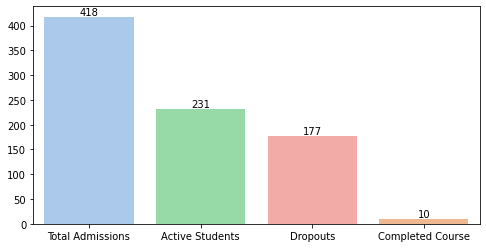

In [16]:
values = [total, n_active, n_dropout, n_complete]
labels = ['Total Admissions', 'Active Students', 'Dropouts', 'Completed Course']

colours = sns.color_palette('pastel')
palette = [colours[0], colours[2], colours[3], colours[1]]

plt.figure(figsize=(8, 4))
ax = sns.barplot(x=labels,
                y=values, 
                palette=palette)
ax.bar_label(ax.containers[0]);

### Cleaning the payments info to get drop-out rates monthly

In [19]:
payments['invoice_date'] = payments['invoice_date'].apply(lambda x: fix_date(x))
payments['receipt_date'] = payments['receipt_date'].apply(lambda x: fix_date(x))

In [20]:
payments['invoice_month'] = payments['invoice_date'].dt.month
payments['invoice_year'] = payments['invoice_date'].dt.year

payments['receipt_month'] = payments['receipt_date'].dt.month
payments['receipt_year'] = payments['receipt_date'].dt.year

In [21]:
payments['diff'] = (payments['receipt_date'] - payments['invoice_date']).dt.days

For each student, pull out the first date of receipt, last date of receipt, avg difference of receipt - invoice date

In [22]:
student_payment_info = pd.concat([payments.groupby('student_name')['receipt_date'].first(),
                                  payments.groupby('student_name')['receipt_date'].last(),
                                  payments.groupby('student_name')['diff'].mean(),
                                  payments.groupby('student_name')['receipt_date'].nunique()
                                 ], axis=1)

student_payment_info.columns = ['first_fee_date', 'last_fee_date', 'avg_diff_from_invoice', 'num_fees']
student_payment_info = student_payment_info.reset_index()

student_payment_info['duration'] = (student_payment_info['last_fee_date']\
                                    - student_payment_info['first_fee_date']).dt.days/30

In [24]:
student_payment_info.head()

,student_name,first_fee_date,last_fee_date,avg_diff_from_invoice,num_fees,duration
0,A G SAMIK SINGH,2019-08-20,2019-08-20,0.000000,1,0.000000
1,A R SHRADHA,2021-12-24,2021-12-24,1.000000,1,0.000000
2,A V HRUSHIKESH,2019-04-15,2019-06-09,13.250000,3,1.833333
3,AADARSH C,2019-08-01,2019-10-05,5.666667,3,2.166667
4,AADHYA RAJESH,2021-02-10,2021-03-15,10.333333,3,1.100000


We can consider last fee date as drop off date if student also has a discontinue status.

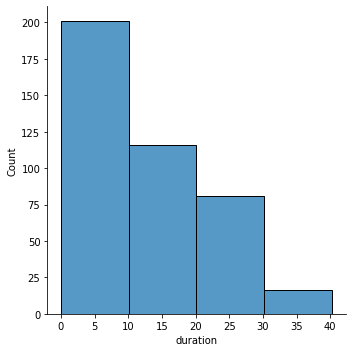

In [29]:
sns.displot(student_payment_info['duration'], bins=4);

In [38]:
dropouts = students[students['status'] == 'DROPOUT']['student_name'].tolist()
active = students[students['status'] == 'ACTIVE']['student_name'].tolist()

In [39]:
# What is the duration distribution for dropout students?
dropout_payment_info = student_payment_info[student_payment_info['student_name'].isin(dropouts)]
active_payment_info = student_payment_info[student_payment_info['student_name'].isin(active)]

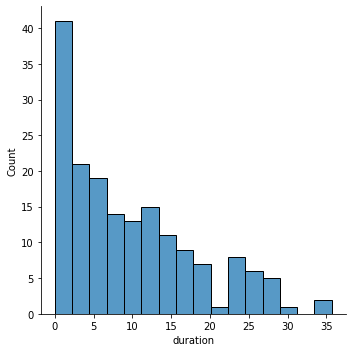

In [49]:
sns.displot(dropout_payment_info['duration'], bins=16);

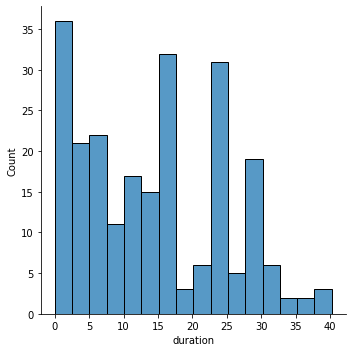

In [50]:
sns.displot(active_payment_info['duration'], bins=16);

**What is the distribution of student dropouts along different points in the journey of the course?**

In [79]:
def categorise_duration(x):
    for i in range(0, 45, 2):
        if (x > i) and (x <= i+2):
            return f'{i if i>=10 else "0" + str(i)}-{i+2 if i+2>=10 else "0" + str(i+2)} months'
    
dropout_payment_info['duration_cat'] = dropout_payment_info['duration'].apply(categorise_duration)

In [84]:
dropout_time = dropout_payment_info['duration_cat'].value_counts().sort_index().reset_index()

In [106]:
dropout_time['clean_index'] = dropout_time['index'].apply(lambda x: '-'.join([i.lstrip('0') if i != '00' else '0' for i in x.split('-')]))

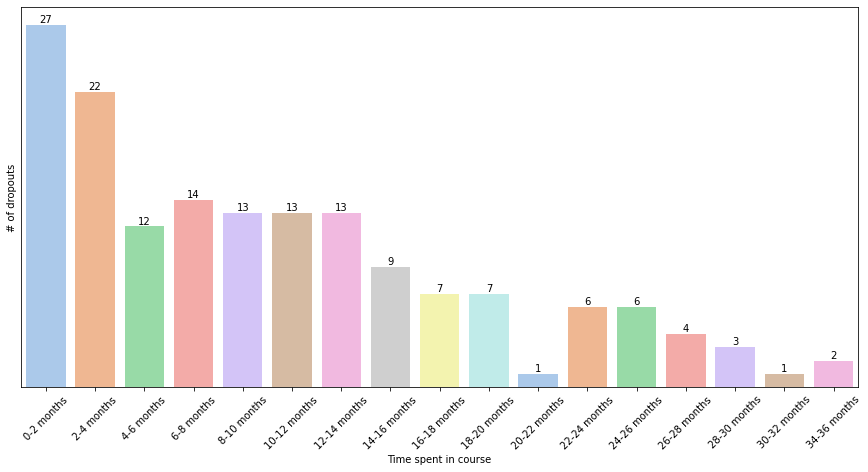

In [108]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(data=dropout_time, x='clean_index', y='duration_cat', palette=colours)
plt.xlabel('Time spent in course')
plt.ylabel('# of dropouts')
plt.xticks(rotation=45)
plt.yticks([])
ax.bar_label(ax.containers[0]);

SIP Sahakarnagar 

6458
adminrukmini
12345678

### Admissions across time

In [114]:
# Is the admission distributed evenly across all months? Or is there some seasonality of sorts?

In [131]:
students = students.dropna(subset=['admission_dt'])

In [137]:
students['admission_month'] = students['admission_dt'].dt.month
students['admission_year'] = students['admission_dt'].dt.year

In [143]:
admissions_monthly = students.groupby(['admission_year', 'admission_month'])['student_name'].count().reset_index()

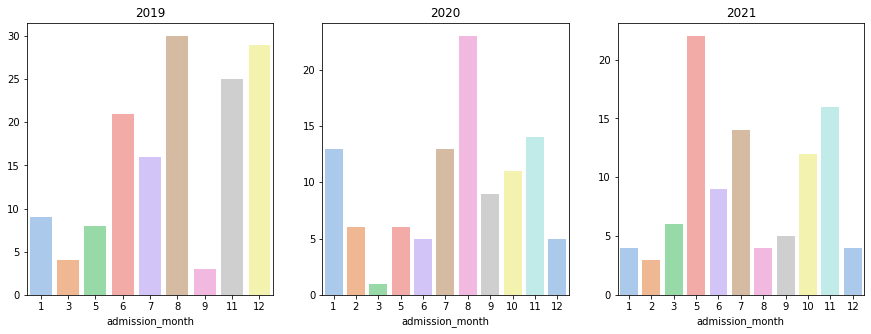

In [161]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, year in enumerate(range(2019, 2022)):
    adm = admissions_monthly[admissions_monthly['admission_year'] == year]
    ax[i].set_title(year)
    sns.barplot(data=adm, x='admission_month', y='student_name', palette=colours, ax=ax[i])
    ax[i].set_ylabel('')

In [177]:
admission_yearly = admissions_monthly.groupby('admission_year')['student_name'].sum().reset_index()
admission_yearly = admission_yearly[admission_yearly['admission_year'] > 2018]

**How has the admission rate has changed over the last 3 years?**

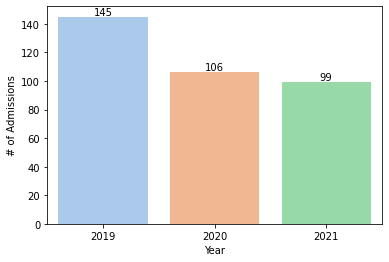

In [192]:
ax = sns.barplot(data=admission_yearly, x='admission_year', y='student_name', palette=colours)
plt.ylabel('# of Admissions')
plt.xlabel('Year')
ax.bar_label(ax.containers[0]);

### Other considerations

Few questions we might be interested in answering:
1. Which level do students mostly dropouts in?
2. What are the months where most dropouts occur?
3. What are the months where most admissions happen?
4. Teacher x Level x Drop-Out rate?
5. Top Schools
6. Top Sources of enquiry/admission
7. Distribution of (dropout date - course start date)
8. Relation between students per batch and dropout rate?
9. Batch-wise dropout? Higher dropout if students in batch from different schools? Or no?